In [73]:
import cv2
import mediapipe as mp
import time
import numpy as np
import pandas as pd
import os
from sklearn.metrics import classification_report, precision_recall_fscore_support, accuracy_score
import matplotlib.pyplot as plt

In [40]:
# Inisialisasi MediaPipe FaceMesh
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, min_detection_confidence=0.5)

# Indeks koordinat yang dipilih untuk mata kiri dan kanan
chosen_left_eye_idxs = [362, 385, 387, 263, 373, 380]
chosen_right_eye_idxs = [33, 160, 158, 133, 153, 144]


label_converter = {'Tertutup':1, 'Terbuka':0}

In [60]:
# Data untuk menyimpan EAR
face_data = {'filename':[],'right_eyes': [], 'left_eyes': [], 'actual_lable':[], 'predicted_label':[]}
# df_results = pd.DataFrame(face_data)

# Fungsi untuk menghitung jarak Euclidean
def eucledianDistance(point1, point2):
    return np.linalg.norm(np.array(point1) - np.array(point2))

# Fungsi untuk menghitung EAR
def EARandMAR(right_eye, left_eye):
    right_ear = (eucledianDistance(right_eye[1], right_eye[5]) + eucledianDistance(right_eye[2], right_eye[4])) / (2 * eucledianDistance(right_eye[0], right_eye[3]))
    left_ear = (eucledianDistance(left_eye[1], left_eye[5]) + eucledianDistance(left_eye[2], left_eye[4])) / (2 * eucledianDistance(left_eye[0], left_eye[3]))
    return right_ear, left_ear

# Fungsi untuk analisis EAR
def EARAnalysis(data, earthresh):
    left_eye, right_eye = data[0], data[1]
    # print(left_eye, right_eye)
    # if right_eye < 0.256694 and left_eye < 0.261488:
    if right_eye < earthresh and left_eye < earthresh:
        # predict = 1  # Mata tertutup
        face_data['predicted_label'].append(1)
        
    else:
        # predict = 0  # Mata terbuka
        face_data['predicted_label'].append(0)
        

# Fungsi untuk menghitung rata-rata AR
def ARMeans(values):
    return np.mean(values) if values else 0



# Fungsi untuk mendeteksi facemesh pada frame
def detect_facemesh(frame, image_name, label, earthresh):
    global face_data
    # Konversi frame ke RGB
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
    # Deteksi facemesh
    results = face_mesh.process(rgb_frame)
    
    # Gambar titik-titik facemesh yang dipilih pada frame
    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            right_eye = [(face_landmarks.landmark[idx].x * frame.shape[1], face_landmarks.landmark[idx].y * frame.shape[0]) for idx in chosen_right_eye_idxs]
            left_eye = [(face_landmarks.landmark[idx].x * frame.shape[1], face_landmarks.landmark[idx].y * frame.shape[0]) for idx in chosen_left_eye_idxs]
            
            right_ear, left_ear = EARandMAR(right_eye, left_eye)
            EARAnalysis([left_ear, right_ear], earthresh)
            # print( right_ear, left_ear)
            
            face_data['filename'].append(image_name)
            face_data['right_eyes'].append(right_ear)
            face_data['left_eyes'].append(left_ear)
            face_data['actual_lable'].append(label_converter[label])
            
            # Gambar titik-titik mata kiri dan kanan
            for (x, y) in right_eye:
                cv2.circle(frame, (int(x), int(y)), 1, (0, 255, 0), -1)
            for (x, y) in left_eye:
                cv2.circle(frame, (int(x), int(y)), 1, (0, 0, 255), -1)
    
    return frame

In [74]:
path_datasets = 'Mata/Mata'

folders = os.listdir(path_datasets)

listofThresh = np.linspace(0.21, 0.31, num=20)

listofThresh

accuracy_history = {'Threshold Value':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1 Score':[]}

In [75]:


for thresh in listofThresh:
    for label in folders:
        path_files = os.path.join(path_datasets, label)
        files = os.listdir(path_files)
        print(path_files)
        for file in files:
            image = cv2.imread(os.path.join(path_files, file))
            detect_facemesh(image, file, label, thresh)
        # plt.imshow(image)
        # break
    report = classification_report(face_data['actual_lable'], face_data['predicted_label'])
    print(f'EAR Threshold : {thresh}\n',
        report
    )
    
    acc_score = accuracy_score(face_data['actual_lable'], face_data['predicted_label'])
    precision, recall, f1, _ = precision_recall_fscore_support(face_data['actual_lable'], face_data['predicted_label'], average=None, labels=[0, 1])
    
    accuracy_history['Threshold Value'].append(thresh)
    accuracy_history['Accuracy'].append(acc_score)
    accuracy_history['Precision'].append(precision)
    accuracy_history['Recall'].append(recall)
    accuracy_history['F1 Score'].append(f1)
    
    face_data = {'filename':[],'right_eyes': [], 'left_eyes': [], 'actual_lable':[], 'predicted_label':[]}
    # break
    # display(files)

Mata/Mata\Terbuka
Mata/Mata\Tertutup
EAR Threshold : 0.21
               precision    recall  f1-score   support

           0       0.53      0.95      0.69       308
           1       0.92      0.38      0.54       415

    accuracy                           0.63       723
   macro avg       0.73      0.67      0.61       723
weighted avg       0.76      0.63      0.60       723

Mata/Mata\Terbuka
Mata/Mata\Tertutup
EAR Threshold : 0.21526315789473682
               precision    recall  f1-score   support

           0       0.55      0.95      0.70       308
           1       0.92      0.42      0.58       415

    accuracy                           0.65       723
   macro avg       0.74      0.69      0.64       723
weighted avg       0.76      0.65      0.63       723

Mata/Mata\Terbuka
Mata/Mata\Tertutup
EAR Threshold : 0.22052631578947368
               precision    recall  f1-score   support

           0       0.57      0.94      0.71       308
           1       0.92      0

In [76]:
# Tampilkan dataframe hasil prediksi
print("DataFrame Hasil Prediksi:")
display(pd.DataFrame(accuracy_history))

DataFrame Hasil Prediksi:


,Threshold Value,Accuracy,Precision,Recall,F1 Score
0,0.210000,0.626556,"[0.5345454545454545, 0.9190751445086706]","[0.9545454545454546, 0.38313253012048193]","[0.6853146853146853, 0.5408163265306123]"
1,0.215263,0.647303,"[0.549718574108818, 0.9210526315789473]","[0.9512987012987013, 0.42168674698795183]","[0.6967895362663495, 0.5785123966942148]"
2,0.220526,0.676349,"[0.5728346456692913, 0.9209302325581395]","[0.9448051948051948, 0.4771084337349398]","[0.7132352941176471, 0.6285714285714286]"
3,0.225789,0.694329,"[0.5893223819301848, 0.9110169491525424]","[0.9318181818181818, 0.5180722891566265]","[0.7220125786163522, 0.6605222734254992]"
4,0.231053,0.701245,"[0.5962343096234309, 0.9061224489795918]","[0.9253246753246753, 0.5349397590361445]","[0.7251908396946565, 0.6727272727272727]"
5,0.236316,0.728907,"[0.6233480176211453, 0.9070631970260223]","[0.9188311688311688, 0.5879518072289157]","[0.7427821522309711, 0.7134502923976608]"
6,0.241579,0.744122,"[0.6407322654462243, 0.9020979020979021]","[0.9090909090909091, 0.6216867469879518]","[0.7516778523489933, 0.7360912981455064]"
7,0.246842,0.759336,"[0.6580188679245284, 0.903010033444816]","[0.9058441558441559, 0.6506024096385542]","[0.7622950819672131, 0.7563025210084033]"
8,0.252105,0.781466,"[0.6856435643564357, 0.9028213166144201]","[0.8993506493506493, 0.6939759036144578]","[0.7780898876404494, 0.784741144414169]"
9,0.257368,0.788382,"[0.6972010178117048, 0.896969696969697]","[0.8896103896103896, 0.7132530120481928]","[0.7817403708987162, 0.7946308724832215]"


In [77]:
pd.DataFrame(accuracy_history).to_csv('History_prediksi.xlsx', index=False)

In [58]:
print(classification_report(face_data['actual_lable'], face_data['predicted_label']))

              precision    recall  f1-score   support

           0       0.71      0.89      0.79       308
           1       0.90      0.73      0.81       415

    accuracy                           0.80       723
   macro avg       0.81      0.81      0.80       723
weighted avg       0.82      0.80      0.80       723



,right_eyes,left_eyes
count,1427.000000,1427.000000
mean,0.256694,0.261488
std,0.076566,0.079683
min,0.064963,0.069389
25%,0.201978,0.199395
50%,0.247643,0.257720
75%,0.312968,0.320340
max,0.682328,0.534210


array([[<AxesSubplot:title={'center':'right_eyes'}>,
        <AxesSubplot:title={'center':'left_eyes'}>]], dtype=object)

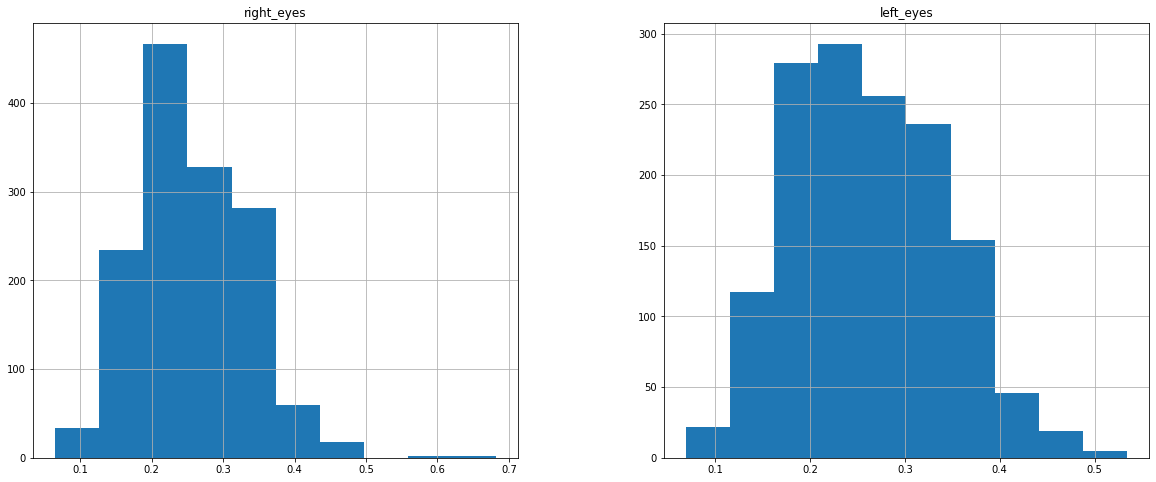

In [32]:
display(
    pd.DataFrame(face_data).describe(),
    pd.DataFrame(face_data).hist(figsize=(20, 8))
)

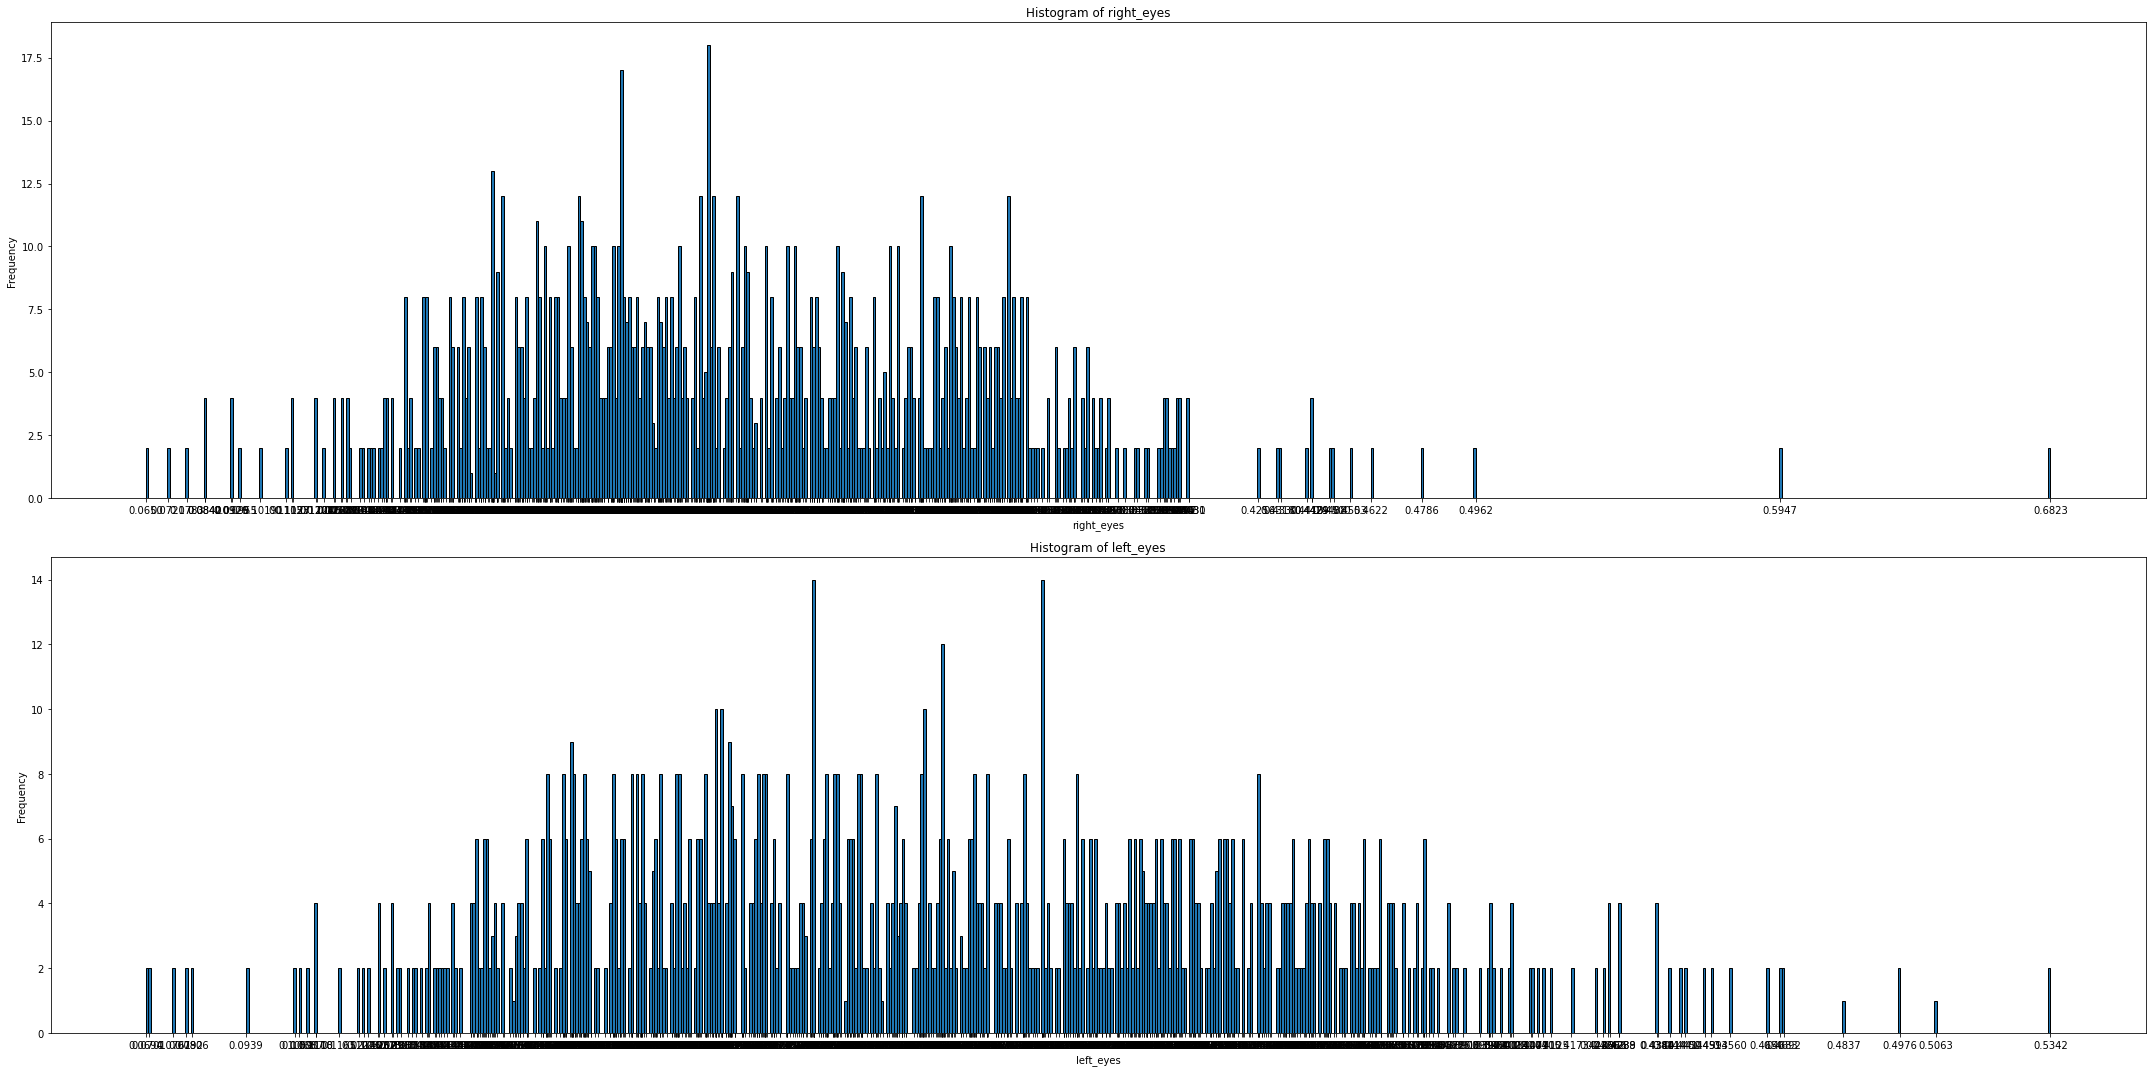

In [36]:
# Create DataFrame
df = pd.DataFrame(face_data)

# Plot histograms for each column
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))

for i, column in enumerate(df.columns[1:]):
    unique_values = df[column].unique()
    bins = len(unique_values)
    
    df[column].plot.hist(ax=axes[i], bins=bins, edgecolor='black')
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xticks(unique_values)  # Set x-ticks to unique values
    axes[i].set_xlabel(column)

plt.tight_layout()
plt.show()

In [36]:
df_results.to_csv('hasil_prediksi.csv', index=False)